In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from npeet import entropy_estimators as ee

from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

import yfinance as yf
import pandas as pd
import sys
import os

from pathlib import Path

In [15]:
scripts_path = Path(os.getcwd()).parent / Path("scripts")
sys.path.insert(0, str(scripts_path))

In [16]:
import warnings
warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

random_state = 42

data_start = "2017-11-09"

### Get data from yfinance

In [18]:
# Retrieve Bitcoin data
btc = yf.Ticker("BTC-USD")
raw = yf.download("BTC-USD", start=data_start,interval="1d")
raw.columns = raw.columns.str.lower()
raw.index.name = raw.index.name.lower()

[*********************100%%**********************]  1 of 1 completed


In [19]:
# Retrieve Etherium data
eth = yf.Ticker("ETH-USD")
raw_eth = yf.download("ETH-USD", start=data_start, interval="1d")
raw_eth.columns = raw_eth.columns.str.lower()
raw_eth.index.name = raw_eth.index.name.lower()

[*********************100%%**********************]  1 of 1 completed


In [20]:
raw_eth.loc["2019-12-20"]

open         1.293844e+02
high         1.297563e+02
low          1.269854e+02
close        1.290661e+02
adj close    1.290661e+02
volume       8.173594e+09
Name: 2019-12-20 00:00:00, dtype: float64

Text(0.5, 1.0, 'BTC Close Price')

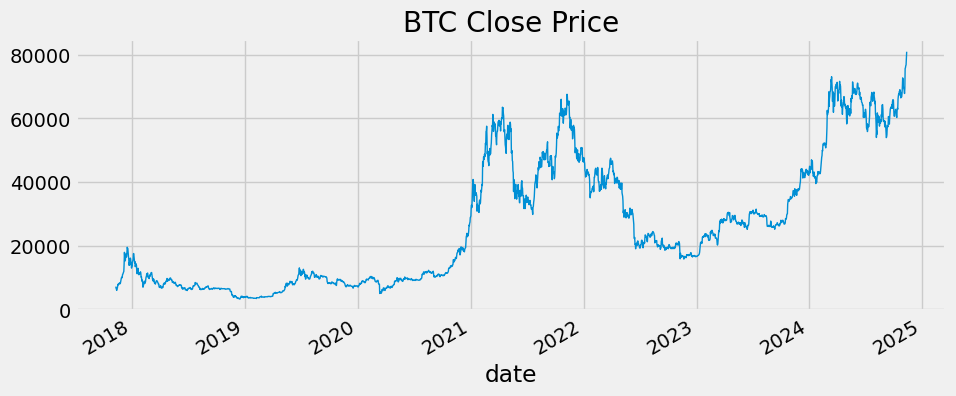

In [5]:
raw.close.plot(linewidth=1, figsize=(10,4))
plt.title("BTC Close Price")

Text(0.5, 1.0, 'ETH Close Price')

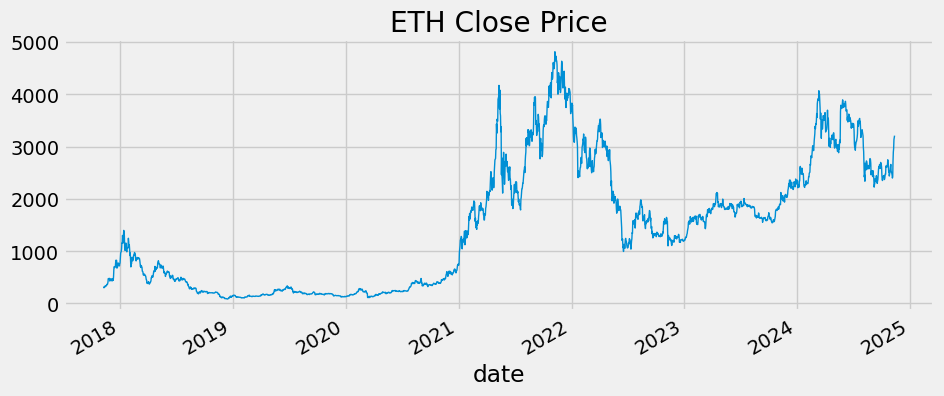

In [6]:
raw_eth.close.plot(linewidth=1, figsize=(10,4))
plt.title("ETH Close Price")

### Check for unit roots

In [7]:
from statsmodels.tsa.stattools import adfuller
# BTC
test = adfuller(raw['close'], regression="n")
print(f"BTC ADF results: {test}")

# ETH
test = adfuller(raw_eth['close'], regression="n")
print(f"ETH ADF results: {test}")

BTC ADF results: (np.float64(0.7023043637756183), np.float64(0.8672933936135944), 27, 2531, {'1%': np.float64(-2.5666239324497915), '5%': np.float64(-1.941106647427883), '10%': np.float64(-1.6167154833441328)}, np.float64(42559.029109141484))
ETH ADF results: (np.float64(-0.2866886186912315), np.float64(0.581194830803158), 17, 2541, {'1%': np.float64(-2.566620451550882), '5%': np.float64(-1.9411062256772975), '10%': np.float64(-1.6167158930165673)}, np.float64(29239.50448494949))


### Check for cointegration

In [ ]:
# Perform Engle-Granger cointegration test
result = coint_johansen(raw[['close']].join(raw_eth['close'], rsuffix="_eth"), det_order=0, k_ar_diff=1)

print(result.lr1)
print(result.cvt)

[21.21076154  0.19367098]
[[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]]


In [75]:
# Perform Engle-Granger cointegration test

subset = slice("2017", "2023")
score, p_value, _ = coint(raw['close'].loc[subset], raw_eth['close'].loc[subset], trend='c')
#score, p_value, _ = coint(raw_eth['close'].loc[subset], raw['close'].loc[subset], trend='c')

print(score, p_value)

# Check if p-value is below alpha of 0.05
if p_value < 0.05:
    print("BTC-USD and ETH-USD are cointegrated.")
else:
    print("BTC-USD and ETH-USD are not cointegrated.")

-3.344936728719485 0.04884497150212574
BTC-USD and ETH-USD are cointegrated.


### Price and Return correlation

In [9]:
close_corr = raw[['close']].join(raw_eth.close, rsuffix='_eth').corr()
return_corr = raw[['close']].pct_change()\
    .join(raw_eth.close.pct_change(), rsuffix='_eth').corr()

print(f"Close price correlation: {close_corr.iloc[0,1]}")
print(f"Returns correlation: {return_corr.iloc[0,1]}")

Close price correlation: 0.9193314889423885
Returns correlation: 0.7776021078559631


### Calculate return spread and standardize

In [21]:
spread = raw[['close']].pct_change() - raw_eth[['close']].pct_change()

In [22]:
spread['mu'] = spread['close'].rolling(window=55).mean()
spread['std'] = spread['close'].rolling(window=55).std()
spread["standardized_spread"] = (spread["close"]- spread.mu) / spread['std']

<Axes: xlabel='date'>

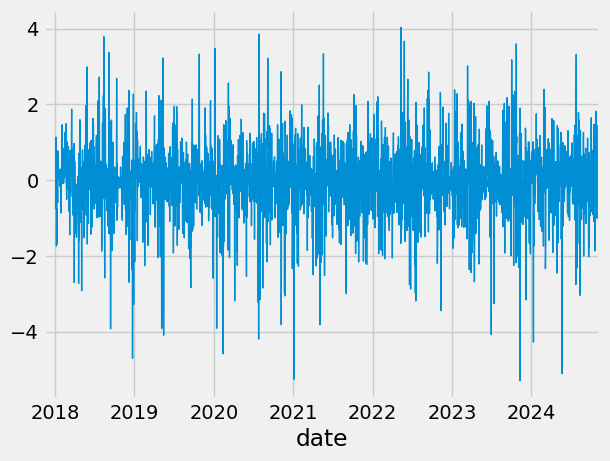

In [23]:
spread["standardized_spread"].plot(linewidth=1)

In [24]:
spread.index = pd.to_datetime(spread.index)
spread = spread.dropna()

### Triple Barrier Labelling

The thresholds for the upper and lower barriers are tuned later after we split the data.

In [25]:
from label import triple_barrier_labeling

# Apply the triple barrier method to your data
label_type = "LPLR"
if label_type == "HPHR":
    upper = 0.173043
    lower = 0.117092
    
else:
    upper = 0.662016
    lower = 0.220194

barriers = triple_barrier_labeling(spread[['standardized_spread']], upper, lower, 2)

In [26]:
barriers.head()

,standardized_spread,label,t1
date,,,
2018-01-03,-0.754725,1,2018-01-04
2018-01-04,0.145974,1,2018-01-05
2018-01-05,1.136838,-1,2018-01-06
2018-01-06,-0.401233,-1,2018-01-07
2018-01-07,-1.737213,1,2018-01-08


In [16]:
barriers['label'].value_counts()

label
-1    1243
 1    1235
 0      26
Name: count, dtype: int64

### Plot the barriers

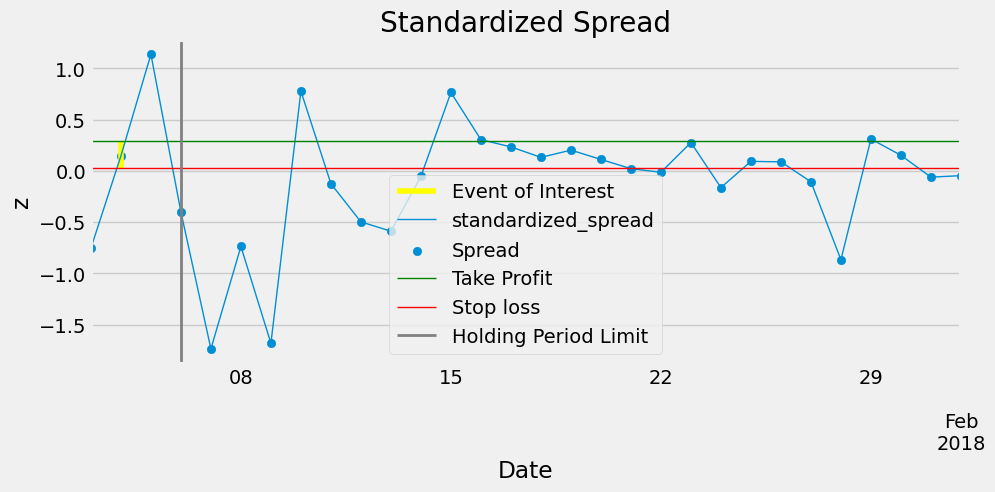

In [17]:

take_profit = 1
stop_loss = 0.8
subset = slice('2018-01-01','2018-02-01')

datapoint = 2

sliced = barriers['standardized_spread'].loc[subset]
plt.vlines(x=sliced.iloc[[1]].index, ymin=sliced.iloc[1]*(1+take_profit), ymax=sliced.iloc[1]*(1-stop_loss), 
           color='yellow',
           label="Event of Interest")
sliced.plot(linewidth=1, figsize=(10,4))
plt.scatter(x=sliced.index, y=sliced, label="Spread")

upper_barriers =  sliced.iloc[1]*(1+take_profit)
lower_barriers = sliced.iloc[1]*(1-stop_loss)

plt.axhline(y=upper_barriers, color="green", linewidth=1, label="Take Profit")
plt.axhline(y=lower_barriers, color="red", linewidth=1, label="Stop loss")
plt.axvline(x=sliced.iloc[[1]].index + pd.DateOffset(days=2), color='grey', linewidth=2, label="Holding Period Limit")
plt.title("Standardized Spread")
plt.xlabel("Date")
plt.ylabel("z")
plt.legend()



In [29]:
# Join asset data
btc_eth = raw.join(raw_eth, rsuffix="_eth")
btc_eth.index = pd.to_datetime(btc_eth.index)

In [30]:
# Join the labels
spread_and_labels = spread.join(barriers[['label', 't1']])

### Feature Engineering

In [32]:
def compute_close_change(data, close_var):
    data_ = data.copy()
    change = data_[close_var].diff()\
        .replace({0:np.nan})\
        .ffill()\
        .dropna()
    return change

def get_bt(data, close_var="close"):
    """ returns a array that with each row being 1 if the close price 
    went up with respect to the previous days close or 0 for down
    """
    data_ = data.copy()
    data_[f'close_change_{close_var}'] = compute_close_change(data, close_var)

    data_.loc[:,f"bt_{close_var}"] = np.sign(data_[f'close_change_{close_var}'])
    return data_

In [33]:
full_data = spread_and_labels.drop("close",axis=1)\
    .join(btc_eth)

full_data = get_bt(full_data, close_var="close")
full_data = get_bt(full_data, close_var="close_eth")

In [35]:
# Calculate the entropy of the bt series
def calculate_rolling_entropy(data:pd.Series, window=30):
    entropy = data.rolling(window=window)\
        .apply(lambda x:ee.entropyd(x))
    return entropy

full_data['bt_close_entropy'] = calculate_rolling_entropy(full_data['bt_close'])
full_data['bt_close_eth_entropy'] = calculate_rolling_entropy(full_data['bt_close_eth'])

In [36]:
# estimate bid ask spread of the assets
def compute_bid_ask_spread(data, close_change_var):
    data_ = data.copy()
    if close_change_var not in data_.columns:
        print(f"Missing {close_change_var} column")
    data_[f'bid_ask_spread_{close_change_var}'] = data_[close_change_var].rolling(window=20)\
    .apply(
        lambda x: np.cov(x, x.shift(1).fillna(0))[0, 1]
    )

    data_[f'bid_ask_spread_{close_change_var}'] = np.sqrt(
        data_[f'bid_ask_spread_{close_change_var}'].apply(lambda x: max(0.0, -x))
    )

    return data_

full_data = compute_bid_ask_spread(full_data, "close_change_close")
full_data = compute_bid_ask_spread(full_data, "close_change_close_eth")

### Rolling cointegration statistics

In [38]:
def compute_coint(x):
    stat = coint(x[:,0], x[:,1], trend='n')[0]
    return stat


def compute_cointegration_stats(closes, window=100):
    closes = closes.copy()
    coint = closes.rolling(window=window)\
        .apply(lambda x : compute_coint(np.column_stack([closes["close"].loc[x.index], closes["close_eth"].loc[x.index]])),
                raw=False)
    return coint

full_data[['close_coint', 'close_eth_coint']] = compute_cointegration_stats(full_data[["close", "close_eth"]], window=100)

### Technical Features

In [39]:
from ta.volatility import AverageTrueRange
from ta.trend import EMAIndicator
from ta.momentum import RSIIndicator

def standardize(x):
    return (x - x.mean()) / x.std()


def compute_vwap(close, high, low, volume):
    hlc3 = (close + high + low) / 3
    vol = hlc3 * volume 
    vwap = vol.groupby(vol.index.day).cumsum()\
        .div(hlc3.groupby(hlc3.index.day).cumsum())
    return vwap


def compute_ema(data, length=9):
    ema = EMAIndicator(data, window=length)
    df = ema.ema_indicator()
    return df

def compute_ATR(high, low, close):
    atr = AverageTrueRange(high, low, close)
    df = atr.average_true_range()
    return df


def upper_crossover(data1, data2):
    shifted1 = data1.shift(1)
    shifted2 = data2.shift(1)

    upper = pd.concat([data1 >= shifted2, shifted1 < shifted2], 
                axis=1)\
            .all(axis=1)
    return upper.astype(int)
    
    
def lower_crossover(data1, data2):
    shifted1 = data1.shift(1)
    shifted2 = data2.shift(1)

    lower = pd.concat([data1 <= shifted2, shifted1 > shifted2], 
                axis=1)\
            .all(axis=1)
    return lower.astype(int)


def compute_rsi(data):
    rsi = RSIIndicator(data)
    rsi = rsi.rsi()
    return rsi


def daily_volatility(data, h=100):
    returns = data.pct_change(freq=pd.Timedelta(days=1))
    rolling_std = returns.ewm(span=h).std()
    return rolling_std


def compute_rolling_ols_betas(data:pd.DataFrame, window=24):
    """Computes a rolling OLS of data on a trend and returns the betas."""
    betas = RollingOLS(
        endog=data,
        exog=sm.add_constant(
            pd.DataFrame(np.arange(data.shape[0]), index=data.index)
        ),
        window=window)\
        .fit(params_only=True)\
        .params\
        .dropna()\
        .drop(['const'], axis=1)
    return betas

In [40]:
def compute_technical_features(data):
    data_ = data.copy()
    for close_var in ["close", "close_eth"]:
        if close_var=="close":
            volume = "volume"
        else:
            volume = "volume_eth"

        data_[f'dollar_volume_{close_var}'] = data_[[close_var, volume]].prod(axis=1)
        data_[f'dollar_vol_1m_{close_var}'] = (data_[f'dollar_volume_{close_var}']\
                        .rolling(window=21)
                        .mean()).values

    for ma_len in [5, 20]:
        data_[f"MA_{ma_len}"] = compute_ema(data['standardized_spread'], length=ma_len)

    data_["vwap_btc"] = compute_vwap(data_.close, data_.high, data_.low, data_.volume)
    data_["vwap_eth"] = compute_vwap(data_.close_eth, data_.high_eth, data_.low_eth, data_.volume_eth)
    data_["MA_upper_co"] = upper_crossover(data_["MA_5"], data_["MA_20"])
    data_["MA_lower_co"] = lower_crossover(data_["MA_5"], data_["MA_20"])
    data_['rsi'] = compute_rsi(data_['standardized_spread'])
    data_['atr_btc'] = compute_ATR(data_.high, data_.low, data_.close)
    data_['atr_eth'] = compute_ATR(data_.high_eth, data_.low_eth, data_.close_eth)
    return data_

full_data = compute_technical_features(full_data)

### Google Trends data

We retrieve the Google trends measures for each asset

In [28]:
from pytrends.request import TrendReq
import pandas as pd

# Initialize pytrends
pytrends = TrendReq(hl='en-US', tz=360)

# Function to fetch data in chunks (due to daily limit for large periods)
def fetch_trends(keyword, start_date, end_date):
    timeframe = f'{start_date} {end_date}'
    pytrends.build_payload([keyword], cat=0, timeframe=timeframe, geo='', gprop='')
    data = pytrends.interest_over_time()
    return data

def get_trends_data(topic, start_date = '2016-09-01', end_date = '2025-09-01'):
    import time
    import random
    # Break the time period into smaller chunks (e.g., 9 months at a time)
    chunks = pd.date_range(start=start_date, end=end_date, freq='9M')

    # Initialize DataFrame to hold results
    trends_data = pd.DataFrame()

    # Loop through chunks and fetch daily data
    for i in range(len(chunks)-1):
        chunk_start = chunks[i].strftime('%Y-%m-%d')
        chunk_end = chunks[i+1].strftime('%Y-%m-%d')
        try:
            print(chunk_start, chunk_end)
            daily_data = fetch_trends(topic, chunk_start, chunk_end)
            trends_data = pd.concat([trends_data, daily_data])
            wait = random.randint(10, 12)
            print(f"waiting {wait} seconds")
            time.sleep(wait)
            print("success")
        except Exception as e:
            print(e)
            print("Limit reached. Waiting 5 minutes")
            time.sleep(60*5)
            try:
                daily_data = fetch_trends(topic, chunk_start, chunk_end)
                trends_data = pd.concat([trends_data, daily_data])
            except Exception as e:
                print(e)
    return trends_data

In [ ]:
bitcoin_trends = get_trends_data("bitcoin", start_date = '2017-09-01', end_date = '2025-09-01')
eth_trends = get_trends_data("etherium", start_date = '2017-09-01', end_date = '2025-09-01')

2017-09-30 2018-06-30
The request failed: Google returned a response with code 429
Limit reached. Waiting 5 minutes
2018-06-30 2019-03-31
waiting 12 seconds
success
2019-03-31 2019-12-31
waiting 10 seconds
success
2019-12-31 2020-09-30
waiting 12 seconds
success
2020-09-30 2021-06-30
waiting 12 seconds
success
2021-06-30 2022-03-31
waiting 12 seconds
success
2022-03-31 2022-12-31
waiting 11 seconds
success
2022-12-31 2023-09-30
waiting 12 seconds
success
2023-09-30 2024-06-30
waiting 10 seconds
success
2024-06-30 2025-03-31
waiting 11 seconds
success
2017-09-30 2018-06-30
The request failed: Google returned a response with code 429
Limit reached. Waiting 5 minutes


In [32]:
bitcoin_trends = bitcoin_trends.drop('isPartial', axis=1)
eth_trends = eth_trends.drop('isPartial', axis=1)

In [33]:
eth_trends = eth_trends[~eth_trends.index.duplicated(keep='first')]
bitcoin_trends = bitcoin_trends[~bitcoin_trends.index.duplicated(keep='first')]

In [34]:
# Join the google trends data
full_data = full_data.join([eth_trends, bitcoin_trends])
full_data['bitcoin'] = full_data['bitcoin'].ffill()
full_data['etherium'] = full_data['etherium'].ffill()

In [27]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2504 entries, 2018-01-03 to 2024-11-11
Data columns (total 40 columns):
 #   Column                                 Non-Null Count  Dtype         
---  ------                                 --------------  -----         
 0   mu                                     2504 non-null   float64       
 1   std                                    2504 non-null   float64       
 2   standardized_spread                    2504 non-null   float64       
 3   label                                  2504 non-null   int64         
 4   t1                                     2504 non-null   datetime64[ns]
 5   open                                   2504 non-null   float64       
 6   high                                   2504 non-null   float64       
 7   low                                    2504 non-null   float64       
 8   close                                  2504 non-null   float64       
 9   adj close                              2504 n

In [41]:
full_data = full_data.dropna()

### Prepare train and test data

In [46]:
# Split the data
train = full_data.loc[:"2023-07-31"]
test = full_data.loc["2023-08-1":].dropna()

In [45]:
test.head()

,mu,std,standardized_spread,label,t1,open,high,low,close,adj close,...,dollar_vol_1m_close_eth,MA_5,MA_20,vwap_btc,vwap_eth,MA_upper_co,MA_lower_co,rsi,atr_btc,atr_eth
date,,,,,,,,,,,,,,,,,,,,,
2023-08-01,0.001712,0.011040,0.463120,-1,2023-08-02,29230.873047,29675.732422,28657.023438,29675.732422,29675.732422,...,1.074692e+13,0.132259,-0.086549,3.112653e+10,1.673811e+10,0,0,52.891911,603.473722,41.618984
2023-08-02,0.001735,0.011034,-0.173422,1,2023-08-03,29704.146484,29987.998047,28946.509766,29151.958984,29151.958984,...,1.074297e+13,0.030366,-0.094823,3.067469e+10,1.701777e+10,0,0,49.595967,634.760476,42.586429
2023-08-03,0.001750,0.011036,0.119276,-1,2023-08-04,29161.812500,29375.707031,28959.488281,29178.679688,29178.679688,...,1.009261e+13,0.060002,-0.074433,3.086510e+10,1.679429e+10,0,0,51.104775,619.150353,41.763099
2023-08-04,0.001322,0.010606,-0.081229,-1,2023-08-05,29174.382812,29302.078125,28885.335938,29074.091797,29074.091797,...,9.534263e+12,0.012925,-0.075080,3.303198e+10,1.833951e+10,0,0,50.000609,604.692627,40.958479
2023-08-05,0.001178,0.010638,-0.588238,1,2023-08-06,29075.388672,29102.464844,28957.796875,29042.126953,29042.126953,...,9.381843e+12,-0.187463,-0.123952,3.130814e+10,1.690368e+10,0,1,47.222208,571.833722,38.865506


In [ ]:
data_path = "./data"
# Save the data
train.to_csv(data_path + "/btc_eth_spread_train2024.csv")
test.to_csv(data_path + "/btc_eth_spread_test2024.csv")

In [39]:
X_train = train.drop(["label", 't1'], axis=1)
y_train = train['label']

X_test = test.drop(["label", 't1'], axis=1)
y_test = test['label']

In [40]:
y_train.value_counts()

label
 1.0    792
-1.0    791
 0.0     20
Name: count, dtype: int64

In [41]:
print(y_test.value_counts())

label
 1.0    232
-1.0    222
 0.0      2
Name: count, dtype: int64


In [42]:
btc_close = raw['close'].loc[:"2022-09-1"]

In [43]:
btc_close = raw['close'].loc[:"2022-09-1"]
ret = btc_close.pct_change()
(ret + 1).cumprod()

date
2017-11-09         NaN
2017-11-10    0.926446
2017-11-11    0.889974
2017-11-12    0.832925
2017-11-13    0.918236
                ...   
2022-08-28    2.746076
2022-08-29    2.841432
2022-08-30    2.771273
2022-08-31    2.806683
2022-09-01    2.817515
Name: close, Length: 1758, dtype: float64

### Setup backtesting

In [3]:
from backtesting import Strategy

In [45]:
train_no_eth = train.drop([col for col in train.columns if "eth" in col], axis=1)
test_no_eth = test.drop([col for col in train.columns if "eth" in col], axis=1)

In [46]:
eth_prices = train[[col for col in train.columns if "eth" in col]]
eth_prices.columns = eth_prices.columns.str.replace("_eth", "")

eth_prices_test = test[[col for col in test.columns if "eth" in col]]
eth_prices_test.columns = eth_prices_test.columns.str.replace("_eth", "")

In [47]:
from backtrader.feeds import PandasData
class SingalData(PandasData):
    cols = train_no_eth.columns
    lines = tuple(cols)
    params = {c: -1 for i, c in enumerate(cols)}
    params = tuple(params.items())

In [48]:
class EthData(PandasData):
    cols = eth_prices.columns
    lines = tuple(cols)
    params = {c: -1 for i, c in enumerate(cols)}
    params = tuple(params.items())

In [4]:
import backtrader as bt
def run_simulation(data, eth, tp, sl, t1_days):

    params = {
        "t1_days": t1_days,
        "upper": tp,
        "lower": sl
    }
    cerebro = bt.Cerebro()
    cerebro.addstrategy(Strategy, 
                        **params             
                    )

    data = SingalData(dataname=data.drop('t1',axis=1))
    cerebro.adddata(data)
    
    eth_data = EthData(dataname=eth)
    cerebro.adddata(eth_data)

    # Set our desired cash start
    start_cash = 1000000
    cerebro.broker.setcash(start_cash)

    # Constanly use only 10% of the cash
    cerebro.addsizer(bt.sizers.PercentSizer, percents=10)
    # Set the commission
    cerebro.broker.setcommission(commission=0.0)
    
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', timeframe=bt.TimeFrame.Days, factor=252)
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    backtest = cerebro.run()
    drawdown = backtest[0].analyzers.drawdown.get_analysis()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    profit = cerebro.broker.getvalue() / start_cash
    drawdown_pct = drawdown.drawdown/100
    drawdown_cash = drawdown.moneydown
    sharpe_ratio = backtest[0].analyzers.sharpe.get_analysis()
    timereturn = backtest[0].analyzers.timereturn.get_analysis()
    cumulative_return = (1 + sum(timereturn.values())) - 1
    sharpe_ratio = sharpe_ratio['sharperatio']*np.sqrt(252)
    weighted_pd = 0.3*(cumulative_return) - 0.7*drawdown_pct
    
    print("Cumulative Return:", cumulative_return)
    print("Sharpe Ratio:", sharpe_ratio)
    print(f"Profit_ratio: {profit}")
    print(f"drawdown pct: {drawdown_pct}")
    print(f"Drawdown cash: {drawdown_cash}")
    print(f"weighted: {weighted_pd}")

    return weighted_pd

In [5]:
def ga_objective(ga_instance, X, solution_idx):
    tp, sl, t1_days = X
    print(tp, sl, t1_days)
    barriers = triple_barrier_labeling(spread[['standardized_spread']], tp, sl, t1_days).loc[:"2022-08-31"]
    
    return run_simulation(train_no_eth, eth_prices, tp, sl, t1_days)

In [1]:
all([False, False])

False

In [60]:
import pygad

num_generations = 100  
num_parents_mating = 6
sol_per_pop = 20  
num_genes = 3  
mutation_percent_genes=10
parent_selection_type = "rank"
crossover_type = "two_points"

gene_space = [{'low': 0.01, 'high': 1}, {'low': 0.01, 'high': 1}, {'low': 1, 'high': 4}]
gene_type = [float, float, int]

# Set up and run the GA
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=ga_objective,
    sol_per_pop=sol_per_pop,
    num_genes=num_genes,
    gene_space=gene_space,
    gene_type=gene_type,
    parent_selection_type = parent_selection_type,
    crossover_type=crossover_type
)

# Run the Genetic Algorithm
ga_instance.run()

# Retrieve and display the best solution
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Best solution:", solution)
print("Best fitness:", solution_fitness)

0.1929411478747639 0.18620076881533584 3
Starting Portfolio Value: 1000000.00
2018-04-13, 00:00:00, BUY EXECUTED, Price: 493.16, Cost: 100044.43, Comm 0.00
2018-04-14, 00:00:00, BUY EXECUTED, Price: 7874.67, Cost: 89752.90, Comm 0.00
2018-04-15, 00:00:00, SELL EXECUTED, Price: 7999.33, Cost: 89752.90, Comm 0.00
2018-04-15, 00:00:00, OPERATION PROFIT, GROSS 1420.84, NET 1420.84
2018-04-16, 00:00:00, BUY EXECUTED, Price: 532.07, Cost: 107938.67, Comm 0.00
2018-04-17, 00:00:00, BUY EXECUTED, Price: 8071.66, Cost: 79471.67, Comm 0.00
2018-04-18, 00:00:00, SELL EXECUTED, Price: 7944.43, Cost: 79471.67, Comm 0.00
2018-04-18, 00:00:00, OPERATION PROFIT, GROSS -1252.68, NET -1252.68
2018-04-19, 00:00:00, BUY EXECUTED, Price: 8159.27, Cost: 79178.24, Comm 0.00
2018-04-20, 00:00:00, SELL EXECUTED, Price: 8286.88, Cost: 79178.24, Comm 0.00
2018-04-20, 00:00:00, OPERATION PROFIT, GROSS 1238.34, NET 1238.34
2018-04-21, 00:00:00, BUY EXECUTED, Price: 616.00, Cost: 249930.12, Comm 0.00
2018-04-22, 00

KeyboardInterrupt: 

In [ ]:
solution, solution_fitness